In [85]:
# The code was removed by Watson Studio for sharing.

<h1 align=center><font size = 5>Capstone Project - The Battle of Neighborhoods</font></h1>

In [86]:
! pip install BeautifulSoup4

In [87]:
! pip install geocoder

In [88]:
! pip install folium # map rendering library

In [89]:
from bs4 import BeautifulSoup
import urllib.request
import csv

In [90]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Preparing the datasets

List of Bali regions and their capitals scrapped from a webpage

In [91]:
# specify the url
urlpage =  'https://en.wikipedia.org/wiki/Bali'

In [92]:
# query the website and return the html to the variable 'page'
page = urllib.request.urlopen(urlpage)
# parse the html using beautiful soup and store in variable 'soup'
soup = BeautifulSoup(page, 'html.parser')

In [93]:
# find results within table
table = soup.find('table', attrs={'class': 'wikitable sortable'})
results = table.find_all('tr')
print('Number of results', len(results))

Number of results 11


In [94]:
# create and write headers to a list 
rows = []
rows.append(['Name', 'Capital'])
print(rows)

[['Name', 'Capital']]


In [95]:
# loop over results
for result in results:
    # find all columns per result
    data = result.find_all('td')
    # check that columns have data 
    if len(data) == 0: 
        continue
     # write columns to variables
    Name = data[0].getText()
    Capital = data[1].getText()
    Name = Name.strip(' ')
    Capital = Capital.strip(' ')
    if(Name=='Totals'):
        break
    rows.append([Name, Capital])
print(rows)

[['Name', 'Capital'], ['Denpasar City', 'Denpasar'], ['Badung Regency', 'Mangupura'], ['Bangli Regency', 'Bangli'], ['Buleleng Regency', 'Singaraja'], ['Gianyar Regency', 'Gianyar'], ['Jembrana Regency', 'Negara'], ['Karangasem Regency', 'Amlapura'], ['Klungkung Regency', 'Semarapura'], ['Tabanan Regency', 'Tabanan']]


In [96]:
from numpy import array

In [97]:
capitalsarray = array (rows)

In [98]:
capitalsarray

array([['Name', 'Capital'],
       ['Denpasar City', 'Denpasar'],
       ['Badung Regency', 'Mangupura'],
       ['Bangli Regency', 'Bangli'],
       ['Buleleng Regency', 'Singaraja'],
       ['Gianyar Regency', 'Gianyar'],
       ['Jembrana Regency', 'Negara'],
       ['Karangasem Regency', 'Amlapura'],
       ['Klungkung Regency', 'Semarapura'],
       ['Tabanan Regency', 'Tabanan']], dtype='<U18')

## Creating and cleaning the Dataframe to be used

In [99]:
# define the dataframe columns
column_names = ['Name', 'Capital']

# instantiate the dataframe
capitals = pd.DataFrame(columns=column_names)

In [100]:
capitals

,Name,Capital


In [101]:
i=1
for data in capitalsarray:
    Name =  capitalsarray[i][0]
    Capital = capitalsarray[i][1]
    
    
    capitals = capitals.append({'Name': Name,
                                          'Capital': Capital,
                                          }, ignore_index=True)
    i += 1
    if i == len(capitalsarray): 
        break

In [102]:
capitals

,Name,Capital
0,Denpasar City,Denpasar
1,Badung Regency,Mangupura
2,Bangli Regency,Bangli
3,Buleleng Regency,Singaraja
4,Gianyar Regency,Gianyar
5,Jembrana Regency,Negara
6,Karangasem Regency,Amlapura
7,Klungkung Regency,Semarapura
8,Tabanan Regency,Tabanan


Ubud happens to be one of the most visited cities in Ubud, so adding it to the dataframe to be considered in the analysis

In [103]:
capitals = capitals.append({'Name': 'Gianyar Regency',
                                          'Capital': 'Ubud',
                                          }, ignore_index=True)

In [104]:
capitals

,Name,Capital
0,Denpasar City,Denpasar
1,Badung Regency,Mangupura
2,Bangli Regency,Bangli
3,Buleleng Regency,Singaraja
4,Gianyar Regency,Gianyar
5,Jembrana Regency,Negara
6,Karangasem Regency,Amlapura
7,Klungkung Regency,Semarapura
8,Tabanan Regency,Tabanan
9,Gianyar Regency,Ubud


Bali cities dataframe size

In [105]:
capitals.shape

(10, 2)

Using a file saved as a project asset containing the latitude and longitude of Bali cities

In [106]:
project.get_files()

[{'name': 'Bali Coordinates.csv',
  'asset_id': '97497a80-431e-4182-8f59-dc8122ffaacb'}]

In [107]:
my_file = project.get_file("Bali Coordinates.csv")

In [108]:
my_file.seek(0)
import pandas as pd
df=pd.read_csv(my_file, nrows=10)

Displaying the coordinates data file content

In [109]:
df

,Name,Latitude,Longitude
0,Denpasar City,-8.672180,115.233550
1,Badung Regency,-8.694210,115.235809
2,Bangli Regency,-7.589500,112.790138
3,Buleleng Regency,-8.110320,115.089394
4,Gianyar Regency,-8.541600,115.323051
5,Jembrana Regency,-8.357130,114.645592
6,Karangasem Regency,-6.702870,108.482811
7,Klungkung Regency,-8.534860,115.404213
8,Tabanan Regency,-8.545040,115.119957
9,Ubud,-8.506854,115.262482


In [110]:
df.index

RangeIndex(start=0, stop=10, step=1)

Merging the dataframes: 1. scrapped from the webpage and 2. the coordinates file

In [111]:
bali= pd.merge(capitals, df, on='Name', how='left')

In [112]:
bali

,Name,Capital,Latitude,Longitude
0,Denpasar City,Denpasar,-8.67218,115.233550
1,Badung Regency,Mangupura,-8.69421,115.235809
2,Bangli Regency,Bangli,-7.58950,112.790138
3,Buleleng Regency,Singaraja,-8.11032,115.089394
4,Gianyar Regency,Gianyar,-8.54160,115.323051
5,Jembrana Regency,Negara,-8.35713,114.645592
6,Karangasem Regency,Amlapura,-6.70287,108.482811
7,Klungkung Regency,Semarapura,-8.53486,115.404213
8,Tabanan Regency,Tabanan,-8.54504,115.119957
9,Gianyar Regency,Ubud,-8.54160,115.323051


Getting the coordinates of Bali

In [113]:
address = 'Bali, ID'

geolocator = Nominatim(user_agent="ID_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Bali City are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Bali City are -8.4560181, 115.270385511912.


## Exploring and clustering the cities in Bali

Exploring Bali

In [173]:
# create map of Bali using latitude and longitude values
map_bali = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Name, Capital in zip(bali['Latitude'], bali['Longitude'], bali['Name'], bali['Capital']):
    label = '{}, {}'.format(Name, Capital)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bali)  
    
map_bali

Using Foursquare to get the venues of Bali cities

In [115]:
CLIENT_ID = '3JNULEZXRMWPP32SJ0EBU0AJSAZ53VV11LMGSTO4WYCEQLPJ' # your Foursquare ID
CLIENT_SECRET = 'UKOQWUA1153JUNJVD3TPKPY31NTDPAFVZHKAU1IQRERRKXGS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3JNULEZXRMWPP32SJ0EBU0AJSAZ53VV11LMGSTO4WYCEQLPJ
CLIENT_SECRET:UKOQWUA1153JUNJVD3TPKPY31NTDPAFVZHKAU1IQRERRKXGS


In [116]:
# type your answer here
LIMIT = 300 # limit of number of venues returned by Foursquare API
radius = 10000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=3JNULEZXRMWPP32SJ0EBU0AJSAZ53VV11LMGSTO4WYCEQLPJ&client_secret=UKOQWUA1153JUNJVD3TPKPY31NTDPAFVZHKAU1IQRERRKXGS&v=20180605&ll=-8.4560181,115.270385511912&radius=10000&limit=300'

Getting the list of venues for Bali from Foursquare (this is only a test)

In [117]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d35f2936c0aa50023973e9b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Gianyar',
  'headerFullLocation': 'Gianyar',
  'headerLocationGranularity': 'city',
  'totalResults': 234,
  'suggestedBounds': {'ne': {'lat': -8.366018009999909,
    'lng': 115.3612048553729},
   'sw': {'lat': -8.54601819000009, 'lng': 115.17956616845109}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '591b9fc895da0c6848703451',
       'name': 'GreenKubu Cafe',
       'location': {'address': 'Jalan Cinta, Banjar pejengaji,Tegallalang',
        'lat': -8.452159016662693,
        'lng': 115.27443408966063,
        'labeledLatLngs': [{'label': 'display',
          'lat':

In [118]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Exploring the list of venues

In [119]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.id','venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.city']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,id,categories,lat,lng,city
0,GreenKubu Cafe,591b9fc895da0c6848703451,Indonesian Restaurant,-8.452159,115.274434,Gianyar
1,Puri Sunia Resort,4e7590fdd22d80eb3345a39e,Resort,-8.467534,115.269759,Ubud
2,Natya Hotel & Resort Ubud,594e04f92a7ab62b4a339bb8,Hotel,-8.467186,115.263415,Bali
3,Komaneka at Tanggayuda Ubud,534cccf4498e63435347942b,Resort,-8.461382,115.249169,NaN
4,Alam Ubud Culture Villas,4e61ff2b62e13e3bce703a72,Resort,-8.456834,115.281944,Tegallalang


In [120]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [121]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #print(url)    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Capital', 
                  'Capital Latitude', 
                  'Capital Longitude', 
                  'Venue', 
                  'Venue id',           
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Getting the list of venues for every citie in Bali using the prepared dataframe

In [122]:
# type your answer here

bali_venues = getNearbyVenues(names=bali['Capital'],
                                   latitudes=bali['Latitude'],
                                   longitudes=bali['Longitude']
                                  )



Denpasar
Mangupura
Bangli
Singaraja
Gianyar
Negara
Amlapura
Semarapura
Tabanan
Ubud


In [123]:
print(bali_venues.shape)

(717, 8)


Analyzing the venues returned from foursquare by city

In [124]:
bali_venues.groupby('Capital').count()

,Capital Latitude,Capital Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
Capital,,,,,,,
Amlapura,100,100,100,100,100,100,100
Bangli,19,19,19,19,19,19,19
Denpasar,100,100,100,100,100,100,100
Gianyar,100,100,100,100,100,100,100
Mangupura,100,100,100,100,100,100,100
Negara,12,12,12,12,12,12,12
Semarapura,68,68,68,68,68,68,68
Singaraja,48,48,48,48,48,48,48
Tabanan,70,70,70,70,70,70,70


In [125]:
print('There are {} uniques categories.'.format(len(bali_venues['Venue Category'].unique())))

There are 137 uniques categories.


Filtering the list of venues to only hotels and resorts

In [126]:
bali_hotels=bali_venues.loc[bali_venues['Venue Category'].isin(['Hotel','Resort'])]

In [127]:
bali_hotels.head()

,Capital,Capital Latitude,Capital Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
16,Denpasar,-8.67218,115.23355,Mahagiri Villas Sanur,4c9db5e354c8a1cd1785864b,-8.689723,115.260765,Resort
29,Denpasar,-8.67218,115.23355,Segara Village Hotel,4b823040f964a520b8cc30e3,-8.683466,115.262965,Resort
36,Denpasar,-8.67218,115.23355,Taksu Hotel Sanur,51cba1327dd2b27bb227ed94,-8.705885,115.255979,Hotel
42,Denpasar,-8.67218,115.23355,Fairmont Sanur Beach Bali,51b177a1454afaec05407031,-8.705770,115.263040,Resort
45,Denpasar,-8.67218,115.23355,Sudamala Suites & Villas,4e775044b0fb9680340072df,-8.707675,115.255988,Resort


In [128]:
print(bali_hotels.shape)

(105, 8)


In [129]:
# create map of Bali using latitude and longitude values
map_bali_hotels = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Capital in zip(bali_hotels['Venue Latitude'], bali_hotels['Venue Longitude'], bali_hotels['Venue']):
    label = '{}'.format(Capital)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bali_hotels)  
    
map_bali_hotels

Clustering the venues (hotels and resorts) on the map for better visibility

In [130]:
from folium import plugins

# let's start again with a clean copy of the map of Bali
bali_map = folium.Map(location = [latitude, longitude], zoom_start = 10)

# instantiate a mark cluster object for the incidents in the dataframe
hotels = plugins.MarkerCluster().add_to(bali_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, Capital in zip(bali_hotels['Venue Latitude'], bali_hotels['Venue Longitude'], bali_hotels['Venue']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=Capital,
    ).add_to(hotels)

# display map
bali_map

In [131]:
bali_hotels_summary =bali_hotels.groupby('Capital').count()
bali_hotels_summary

,Capital Latitude,Capital Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category
Capital,,,,,,,
Amlapura,13,13,13,13,13,13,13
Bangli,2,2,2,2,2,2,2
Denpasar,14,14,14,14,14,14,14
Gianyar,21,21,21,21,21,21,21
Mangupura,17,17,17,17,17,17,17
Negara,1,1,1,1,1,1,1
Semarapura,3,3,3,3,3,3,3
Singaraja,7,7,7,7,7,7,7
Tabanan,6,6,6,6,6,6,6


In [132]:
bali_hotels_summary.rename(columns={'Capital Latitude':'Total'}, inplace=True)

In [133]:
bali_hotels_summary.drop(['Capital Longitude', 'Venue','Venue Latitude', 'Venue Longitude', 'Venue Category','Venue id'], axis=1)

,Total
Capital,
Amlapura,13
Bangli,2
Denpasar,14
Gianyar,21
Mangupura,17
Negara,1
Semarapura,3
Singaraja,7
Tabanan,6


Visualizing the venues (hotels and resorts) by city

In [134]:
# np.histogram returns 2 values
count, bin_edges = np.histogram(bali_hotels_summary['Total'])

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

[2 1 1 1 0 0 2 0 1 2]
[ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21.]


In [135]:
import matplotlib as mpl
import matplotlib.pyplot as plt

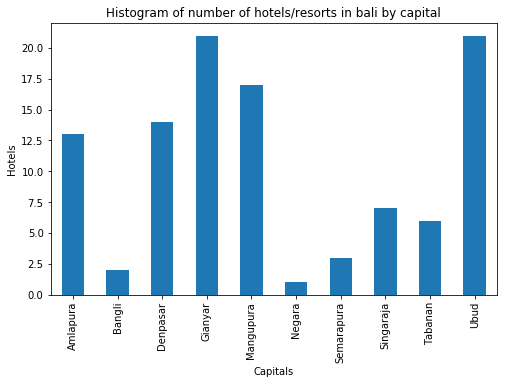

In [136]:
bali_hotels_summary['Total'].plot(kind='bar', figsize=(8, 5))

plt.title('Histogram of number of hotels/resorts in bali by capital') # add a title to the histogram
plt.ylabel('Hotels') # add y-label
plt.xlabel('Capitals') # add x-label

plt.show()

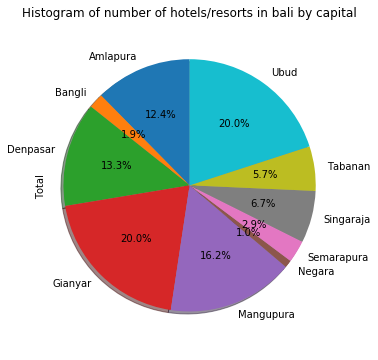

In [137]:
bali_hotels_summary['Total'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,       # add shadow      
                            )

plt.title('Histogram of number of hotels/resorts in bali by capital')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

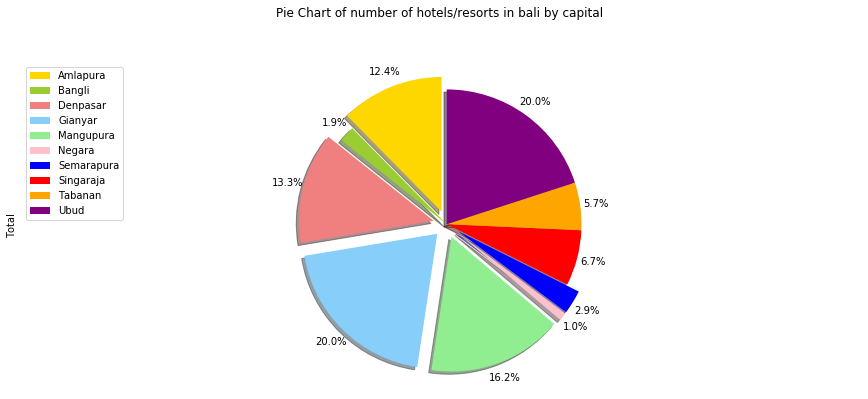

In [174]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink','blue','red','orange','purple']
explode_list = [0.1, 0, 0.1, 0.1, 0.1, 0.1,0.1,0,0,0] # ratio for each continent with which to offset each wedge.

bali_hotels_summary['Total'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Pie Chart of number of hotels/resorts in bali by capital', y=1.12) 

plt.axis('equal') 


# add legend
plt.legend(labels=bali_hotels_summary.index, loc='upper left') 

plt.show()

## Clustering all the venues in the cities in Bali

In [139]:
# one hot encoding
Bali_onehot = pd.get_dummies(bali_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Bali_onehot['Capital'] = bali_venues['Capital'] 

# move neighborhood column to the first column
fixed_columns = [Bali_onehot.columns[-1]] + list(Bali_onehot.columns[:-1])
Bali_onehot = Bali_onehot[fixed_columns]

Bali_onehot.head()

,Capital,Airport,Airport Food Court,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Balinese Restaurant,Bar,Batik Shop,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Building,Burger Joint,Café,Campground,Cemetery,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cultural Center,Department Store,Dim Sum Restaurant,Diner,Discount Store,Dive Shop,Donut Shop,Exhibit,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,General Entertainment,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Harbor / Marina,High School,Historic Site,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Juice Bar,Karaoke Bar,Lounge,Market,Massage Studio,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Mountain,Movie Theater,Multiplex,Museum,National Park,Nature Preserve,New American Restaurant,Night Market,Noodle House,Office,Outdoors & Recreation,Park,Peruvian Restaurant,Pie Shop,Pizza Place,Plaza,Pool,Recreation Center,Resort,Restaurant,Rock Club,Salad Place,Satay Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Snack Place,Soccer Stadium,Soup Place,Souvenir Shop,Spa,Stables,Steakhouse,Sundanese Restaurant,Supermarket,Surf Spot,Sushi Restaurant,Temple,Thai Restaurant,Theater,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfall,Wings Joint,Yoga Studio,Zoo Exhibit
0,Denpasar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Denpasar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Denpasar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Denpasar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Denpasar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [140]:
Bali_grouped = Bali_onehot.groupby('Capital').mean().reset_index()
Bali_grouped

,Capital,Airport,Airport Food Court,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Balinese Restaurant,Bar,Batik Shop,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Building,Burger Joint,Café,Campground,Cemetery,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cultural Center,Department Store,Dim Sum Restaurant,Diner,Discount Store,Dive Shop,Donut Shop,Exhibit,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,General Entertainment,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Harbor / Marina,High School,Historic Site,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Juice Bar,Karaoke Bar,Lounge,Market,Massage Studio,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Mountain,Movie Theater,Multiplex,Museum,National Park,Nature Preserve,New American Restaurant,Night Market,Noodle House,Office,Outdoors & Recreation,Park,Peruvian Restaurant,Pie Shop,Pizza Place,Plaza,Pool,Recreation Center,Resort,Restaurant,Rock Club,Salad Place,Satay Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Shopping Plaza,Snack Place,Soccer Stadium,Soup Place,Souvenir Shop,Spa,Stables,Steakhouse,Sundanese Restaurant,Supermarket,Surf Spot,Sushi Restaurant,Temple,Thai Restaurant,Theater,Tourist Information Center,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfall,Wings Joint,Yoga Studio,Zoo Exhibit
0,Amlapura,0.01,0.000000,0.000000,0.020000,0.00,0.010000,0.040000,0.040000,0.010000,0.000000,0.030000,0.000000,0.000000,0.01,0.000000,0.000000,0.00,0.010000,0.00,0.000000,0.01,0.010000,0.000000,0.000000,0.00,0.030000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.00,0.020000,0.000000,0.000000,0.020000,0.010000,0.030000,0.00,0.00,0.010000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.010000,0.000000,0.010000,0.01,0.000000,0.000000,0.00,0.000000,0.000000,0.010000,0.000000,0.130000,0.000000,0.00,0.00,0.140000,0.00,0.000000,0.02,0.000000,0.00,0.010000,0.01,0.01,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.01,0.000000,0.000000,0.00,0.00,0.000000,0.02,0.00,0.000000,0.000000,0.00,0.00,0.01,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.01,0.00,0.000000,0.010000,0.020000,0.01,0.000000,0.02,0.03,0.01,0.000000,0.000000,0.01,0.01,0.020000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.010000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000
1,Bangli,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.00,0.00,0.052632,0.00,0.00,0.000000,0.105263,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.105263,0.000000,0.00,0.00,0.526316,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.052632,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000
2,Denpasar,0.00,0.000000,0.000000,0.000000,0.00,0.010000,0.

In [141]:
Bali_grouped.shape

(10, 138)

Frequencies of the venue categories for every city (top 5)

In [142]:
num_top_venues = 5

for hood in Bali_grouped['Capital']:
    print("----"+hood+"----")
    temp = Bali_grouped[Bali_grouped['Capital'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amlapura----
                   venue  freq
0  Indonesian Restaurant  0.14
1                  Hotel  0.13
2            Coffee Shop  0.04
3    Arts & Crafts Store  0.04
4       Asian Restaurant  0.04


----Bangli----
                   venue  freq
0  Indonesian Restaurant  0.53
1            Gas Station  0.11
2                  Hotel  0.11
3                  Plaza  0.05
4             Food Truck  0.05


----Denpasar----
                   venue  freq
0                  Hotel  0.09
1                   Café  0.09
2  Indonesian Restaurant  0.09
3       Asian Restaurant  0.05
4                 Resort  0.05


----Gianyar----
                           venue  freq
0                         Resort  0.14
1                          Hotel  0.07
2          Indonesian Restaurant  0.06
3               Asian Restaurant  0.05
4  Vegetarian / Vegan Restaurant  0.04


----Mangupura----
                   venue  freq
0                  Hotel  0.11
1  Indonesian Restaurant  0.10
2                   Café

In [143]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [169]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Capital']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
capitals_venues_sorted = pd.DataFrame(columns=columns)
capitals_venues_sorted['Capital'] = Bali_grouped['Capital']

for ind in np.arange(Bali_grouped.shape[0]):
    capitals_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Bali_grouped.iloc[ind, :], num_top_venues)

capitals_venues_sorted

,Capital,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amlapura,Indonesian Restaurant,Hotel,Arts & Crafts Store,Asian Restaurant,Restaurant,Coffee Shop,Soup Place,Bakery,Diner,Café
1,Bangli,Indonesian Restaurant,Hotel,Gas Station,Train Station,Fried Chicken Joint,Food Truck,Café,Plaza,Arts & Crafts Store,Forest
2,Denpasar,Hotel,Indonesian Restaurant,Café,Coffee Shop,Resort,Asian Restaurant,Bakery,Chinese Restaurant,Restaurant,Spa
3,Gianyar,Resort,Hotel,Indonesian Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Bistro,Yoga Studio,Café,Spa,Restaurant
4,Mangupura,Hotel,Indonesian Restaurant,Café,Coffee Shop,Resort,Spa,Bakery,Restaurant,Chinese Restaurant,Gym
5,Negara,Indonesian Restaurant,Diner,Hotel,Snack Place,Grocery Store,Breakfast Spot,Building,Food & Drink Shop,Bakery,Campground
6,Semarapura,Indonesian Restaurant,Beach,Field,Resort,General Entertainment,Harbor / Marina,Seafood Restaurant,History Museum,Convenience Store,Miscellaneous Shop
7,Singaraja,Beach,Indonesian Restaurant,Resort,Hotel,Asian Restaurant,Café,Beach Bar,Bar,Seafood Restaurant,Field
8,Tabanan,Indonesian Restaurant,Café,Resort,Beach,BBQ Joint,Restaurant,Food Court,Chinese Restaurant,Convenience Store,Hotel
9,Ubud,Resort,Hotel,Indonesian Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Bistro,Yoga Studio,Café,Spa,Restaurant


Using K means to cluster the venues

In [170]:
# set number of clusters
kclusters = 6

Bali_grouped_clustering = Bali_grouped.drop('Capital', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Bali_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 2, 4, 2, 3, 5, 0, 2, 4], dtype=int32)

In [171]:
# add clustering labels
capitals_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bali_merged = bali_venues

# merge bali_grouped with bali to add latitude/longitude for each neighborhood
bali_merged = bali_merged.join(capitals_venues_sorted.set_index('Capital'), on='Capital')

bali_merged.head() # check the first columns!

,Capital,Capital Latitude,Capital Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Denpasar,-8.67218,115.23355,Warung Sari Manis,4f8cd8f7e4b07efba0ff86c1,-8.667076,115.234696,Indonesian Restaurant,2,Hotel,Indonesian Restaurant,Café,Coffee Shop,Resort,Asian Restaurant,Bakery,Chinese Restaurant,Restaurant,Spa
1,Denpasar,-8.67218,115.23355,Goemerot Restaurant,578e0da4498e57a5d7518587,-8.675372,115.227971,Restaurant,2,Hotel,Indonesian Restaurant,Café,Coffee Shop,Resort,Asian Restaurant,Bakery,Chinese Restaurant,Restaurant,Spa
2,Denpasar,-8.67218,115.23355,Warung Sate Plecing Mak Lukluk,51c3bbc1498e56f1f605f195,-8.673840,115.243818,Indonesian Restaurant,2,Hotel,Indonesian Restaurant,Café,Coffee Shop,Resort,Asian Restaurant,Bakery,Chinese Restaurant,Restaurant,Spa
3,Denpasar,-8.67218,115.23355,"Siomay Pak Lebah, jln Dr. Muwardi Renon-Denpasar",51df9453498e717286886b96,-8.670610,115.237146,Diner,2,Hotel,Indonesian Restaurant,Café,Coffee Shop,Resort,Asian Restaurant,Bakery,Chinese Restaurant,Restaurant,Spa
4,Denpasar,-8.67218,115.23355,Cengkih Jintens Resto,56ebf89a498e27e293bb1236,-8.668728,115.238817,Sundanese Restaurant,2,Hotel,Indonesian Restaurant,Café,Coffee Shop,Resort,Asian Restaurant,Bakery,Chinese Restaurant,Restaurant,Spa


Visualizing the clusters

In [172]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bali_merged['Venue Latitude'], bali_merged['Venue Longitude'], bali_merged['Venue'], bali_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [148]:
#bali_merged.loc[bali_merged['Cluster Labels'] == 1, bali_merged.columns[[0] + list(range(5, bali_merged.shape[1]))]]

In [149]:
## Exploring the Bali hotel foursquare "likes"

In [150]:
# type your answer here
LIMIT = 300 # limit of number of venues returned by Foursquare API
radius = 10000 # define radius
url1 = 'https://api.foursquare.com/v2/venues/591b9fc895da0c6848703451/likes?&client_id={}&client_secret={}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    radius, 
    LIMIT)
url1 # display URL

'https://api.foursquare.com/v2/venues/591b9fc895da0c6848703451/likes?&client_id=3JNULEZXRMWPP32SJ0EBU0AJSAZ53VV11LMGSTO4WYCEQLPJ&client_secret=UKOQWUA1153JUNJVD3TPKPY31NTDPAFVZHKAU1IQRERRKXGS&v=20180605&radius=10000&limit=300'

In [151]:
def getNearbyVenuesLikes(ids):
    
    venues_list=[]
    i=0
    for venueid in ids:
        #print(venueid)    
        #print(i)
        # create the API request URL
        url2 = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            venueid,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #print(url2)    
        # make the GET request
        results = requests.get(url2).json()["response"]['likes']
        #print(results) 
        # return only relevant information for each nearby venue
        venues_list.append([(venueid, results ['count'])])
        
    venues_likes = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues_likes.columns = ['Venue id', 
                  'Venue Likes']
    
    return(venues_likes)

In [152]:
bali_venues_likes = getNearbyVenuesLikes(ids=bali_hotels['Venue id'])

In [153]:
bali_venues_likes.head()

,Venue id,Venue Likes
0,4c9db5e354c8a1cd1785864b,24
1,4b823040f964a520b8cc30e3,47
2,51cba1327dd2b27bb227ed94,36
3,51b177a1454afaec05407031,74
4,4e775044b0fb9680340072df,28


In [154]:
bali_hotels_likes= pd.merge(bali_hotels, bali_venues_likes, on='Venue id', how='left')

In [155]:
bali_hotels_likes.head()

,Capital,Capital Latitude,Capital Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category,Venue Likes
0,Denpasar,-8.67218,115.23355,Mahagiri Villas Sanur,4c9db5e354c8a1cd1785864b,-8.689723,115.260765,Resort,24
1,Denpasar,-8.67218,115.23355,Mahagiri Villas Sanur,4c9db5e354c8a1cd1785864b,-8.689723,115.260765,Resort,24
2,Denpasar,-8.67218,115.23355,Segara Village Hotel,4b823040f964a520b8cc30e3,-8.683466,115.262965,Resort,47
3,Denpasar,-8.67218,115.23355,Segara Village Hotel,4b823040f964a520b8cc30e3,-8.683466,115.262965,Resort,47
4,Denpasar,-8.67218,115.23355,Taksu Hotel Sanur,51cba1327dd2b27bb227ed94,-8.705885,115.255979,Hotel,36


In [156]:
bali_hotels_likes.tail()

,Capital,Capital Latitude,Capital Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category,Venue Likes
174,Ubud,-8.5416,115.323051,Hotel Pertiwi Bisma I,545c9ee5498edbbeb939e35f,-8.514011,115.256770,Hotel,47
175,Ubud,-8.5416,115.323051,Wapa Di Ume Resort and Spa,536468b1498e602fbe536059,-8.490781,115.264914,Resort,31
176,Ubud,-8.5416,115.323051,Wapa Di Ume Resort and Spa,536468b1498e602fbe536059,-8.490781,115.264914,Resort,31
177,Ubud,-8.5416,115.323051,Alaya Resort Jembawan,57a51838498e69a1d8e6b75c,-8.510393,115.267315,Resort,14
178,Ubud,-8.5416,115.323051,Alaya Resort Jembawan,57a51838498e69a1d8e6b75c,-8.510393,115.267315,Resort,14


In [157]:
bali_hotels_likes.shape

(179, 9)

Most liked hotels

In [158]:
bali_hotels_likes.nlargest(10, ['Venue Likes']) 

,Capital,Capital Latitude,Capital Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category,Venue Likes
52,Mangupura,-8.69421,115.235809,Sheraton Bali Kuta Resort,4dff735e628421556008ee8c,-8.717966,115.169126,Hotel,230
112,Amlapura,-6.70287,108.482811,Aston Cirebon Hotel & Convention Center,50873793e4b095f041ac562d,-6.722276,108.539745,Hotel,212
53,Mangupura,-8.69421,115.235809,The Stones Hotel,50481fb4e4b06b582141a247,-8.711445,115.169402,Hotel,183
76,Gianyar,-8.54160,115.323051,Komune Resort and Beach Club,509f153ee4b0df8f7f4d0409,-8.598222,115.338460,Resort,165
77,Gianyar,-8.54160,115.323051,Komune Resort and Beach Club,509f153ee4b0df8f7f4d0409,-8.598222,115.338460,Resort,165
144,Ubud,-8.54160,115.323051,Komune Resort and Beach Club,509f153ee4b0df8f7f4d0409,-8.598222,115.338460,Resort,165
145,Ubud,-8.54160,115.323051,Komune Resort and Beach Club,509f153ee4b0df8f7f4d0409,-8.598222,115.338460,Resort,165
16,Denpasar,-8.67218,115.233550,"Ramada Encore Hotel & Resort, Seminyak-Bali",54704d91498ed714fb972282,-8.685195,115.176169,Hotel,120
17,Denpasar,-8.67218,115.233550,"Ramada Encore Hotel & Resort, Seminyak-Bali",54704d91498ed714fb972282,-8.685195,115.176169,Hotel,120
46,Mangupura,-8.69421,115.235809,"Ramada Encore Hotel & Resort, Seminyak-Bali",54704d91498ed714fb972282,-8.685195,115.176169,Hotel,120
